Imports de base

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


Charger les données

In [7]:

df = pd.read_csv("data_churn.csv")

Aperçu des données

In [8]:
print(df.head())
print(df.info())
print(df['Churn'].value_counts())

   Unnamed: 0  customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0           0  7590-VHVEG  Female              0     Yes         No       1   
1           1  5575-GNVDE    Male              0      No         No      34   
2           2  3668-QPYBK    Male              0      No         No       2   
3           3  7795-CFOCW    Male              0      No         No      45   
4           4  9237-HQITU  Female              0      No         No       2   

  PhoneService     MultipleLines InternetService  ... DeviceProtection  \
0           No  No phone service             DSL  ...               No   
1          Yes                No             DSL  ...              Yes   
2          Yes                No             DSL  ...               No   
3           No  No phone service             DSL  ...              Yes   
4          Yes                No     Fiber optic  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0 

Analyse et gestion des données manquantes


=== Analyse des données manquantes ===

Colonnes avec des données manquantes :
                 Nombre  Pourcentage
OnlineBackup       5634    79.994321
TotalCharges       2113    30.001420
TechSupport        1526    21.666903
StreamingTV        1526    21.666903
StreamingMovies    1526    21.666903

Nombre total de lignes avec au moins une valeur manquante : 6273
Pourcentage de lignes avec des données manquantes : 89.07%


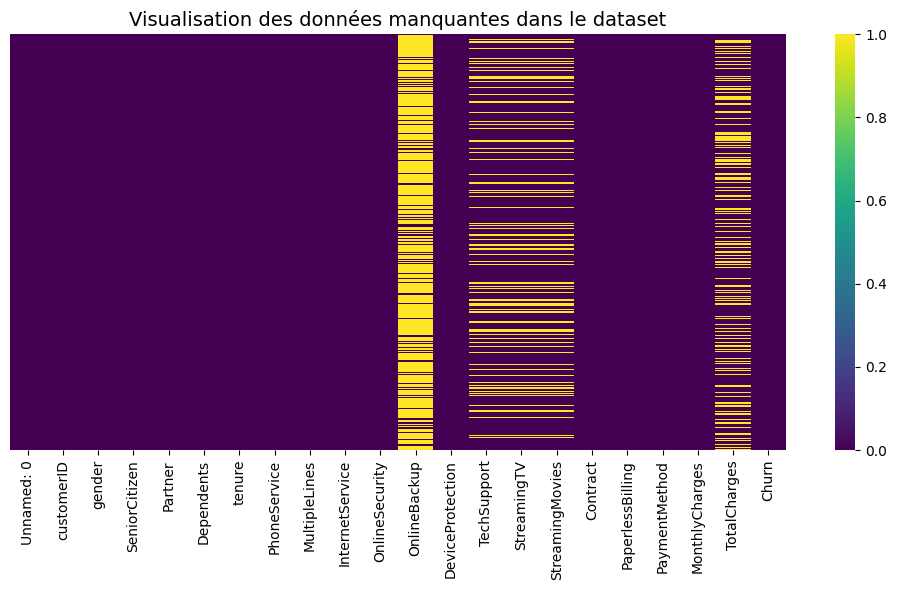

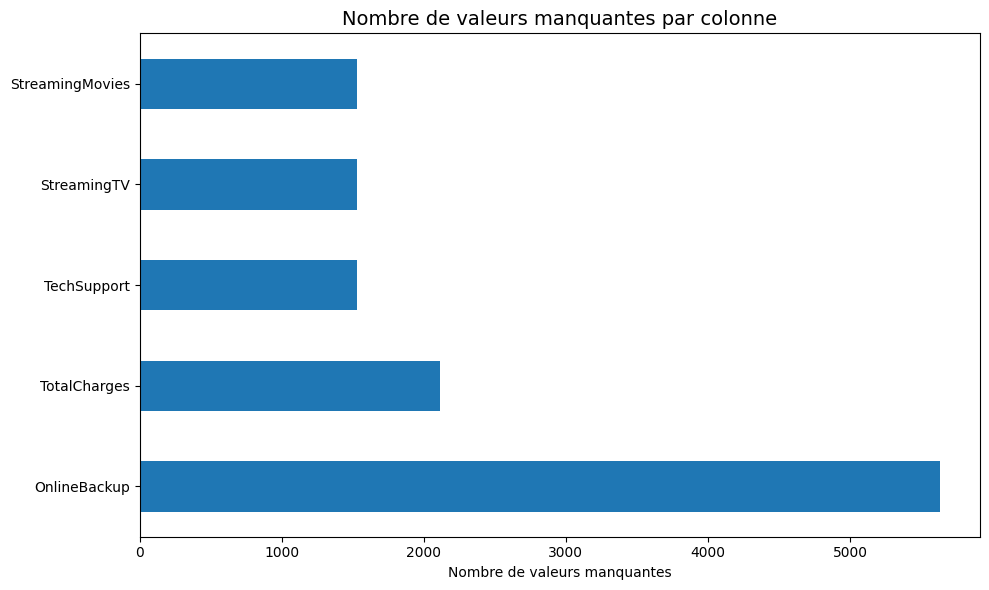

In [9]:
# Analyse des données manquantes
print("=== Analyse des données manquantes ===\n")

# Nombre et pourcentage de valeurs manquantes par colonne
missing_data = pd.DataFrame({
    'Nombre': df.isnull().sum(),
    'Pourcentage': (df.isnull().sum() / len(df)) * 100
})
missing_data = missing_data[missing_data['Nombre'] > 0].sort_values('Nombre', ascending=False)

if len(missing_data) > 0:
    print("Colonnes avec des données manquantes :")
    print(missing_data)
    print(f"\nNombre total de lignes avec au moins une valeur manquante : {df.isnull().any(axis=1).sum()}")
    print(f"Pourcentage de lignes avec des données manquantes : {(df.isnull().any(axis=1).sum() / len(df)) * 100:.2f}%")
    
    # Visualisation des données manquantes
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title("Visualisation des données manquantes dans le dataset", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Visualisation du nombre de valeurs manquantes par colonne
    if len(missing_data) > 0:
        plt.figure(figsize=(10, 6))
        missing_data['Nombre'].plot(kind='barh')
        plt.title("Nombre de valeurs manquantes par colonne", fontsize=14)
        plt.xlabel("Nombre de valeurs manquantes")
        plt.tight_layout()
        plt.show()
else:
    print("Aucune donnée manquante détectée dans le dataset.")


In [10]:
# Gestion des lignes avec des données manquantes
print("=== Gestion des données manquantes ===\n")

# Compter les lignes avant suppression
nb_lignes_avant = len(df)
print(f"Nombre de lignes avant traitement : {nb_lignes_avant}")

# Supprimer les lignes avec trop de valeurs manquantes
seuil_manquantes = 0.5  # 50% des colonnes
df = df[df.isnull().sum(axis=1) / len(df.columns) < seuil_manquantes]

# Compter les lignes après suppression
nb_lignes_apres = len(df)
nb_lignes_supprimees = nb_lignes_avant - nb_lignes_apres

print(f"Nombre de lignes après suppression : {nb_lignes_apres}")
print(f"Nombre de lignes supprimées : {nb_lignes_supprimees}")
print(f"Pourcentage de données conservées : {(nb_lignes_apres / nb_lignes_avant) * 100:.2f}%")

# Vérifier s'il reste des données manquantes
if df.isnull().sum().sum() > 0:
    print("\nIl reste des données manquantes qui seront traitées dans la section de nettoyage.")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("\nToutes les données manquantes ont été traitées.")


=== Gestion des données manquantes ===

Nombre de lignes avant traitement : 7043
Nombre de lignes après suppression : 7043
Nombre de lignes supprimées : 0
Pourcentage de données conservées : 100.00%

Il reste des données manquantes qui seront traitées dans la section de nettoyage.
OnlineBackup       5634
TechSupport        1526
StreamingTV        1526
StreamingMovies    1526
TotalCharges       2113
dtype: int64


Nettoyage des données

In [11]:
# 1. Supprimer les colonnes inutiles
df = df.drop(columns=["Unnamed: 0", "customerID"])

# 2. Convertir TotalCharges en numérique et gérer les NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0)  # clients très récents = pas encore payé

# 3. Remplacer les NaN dans les colonnes services par "No"
cols_with_na = ["OnlineBackup", "TechSupport", "StreamingTV", "StreamingMovies"]
for col in cols_with_na:
    df[col] = df[col].fillna("No")

# 4. Uniformiser les modalités "No internet service" et "No phone service"
replace_map = {
    "No internet service": "No",
    "No phone service": "No"
}
df = df.replace(replace_map)

# 5. Encoder la cible (Churn) en binaire
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# 6. Vérifier les colonnes numériques / catégorielles
categorical_cols = df.select_dtypes(include="object").columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

print("Colonnes catégorielles :", list(categorical_cols))
print("Colonnes numériques :", list(numeric_cols))

# # 7. Encoder les variables catégorielles (LabelEncoder)
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col].astype(str))

# OneHot Encoding (mieux)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Vérif finale
print(df.info())
print(df.head())


Colonnes catégorielles : ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Colonnes numériques : ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   tenure                                 7043 non-null   int64  
 2   MonthlyCharges                         7043 non-null   float64
 3   TotalCharges                           7043 non-null   float64
 4   Churn                                  7043 non-null   int64  
 5   gender_Male                            7043 non-null  

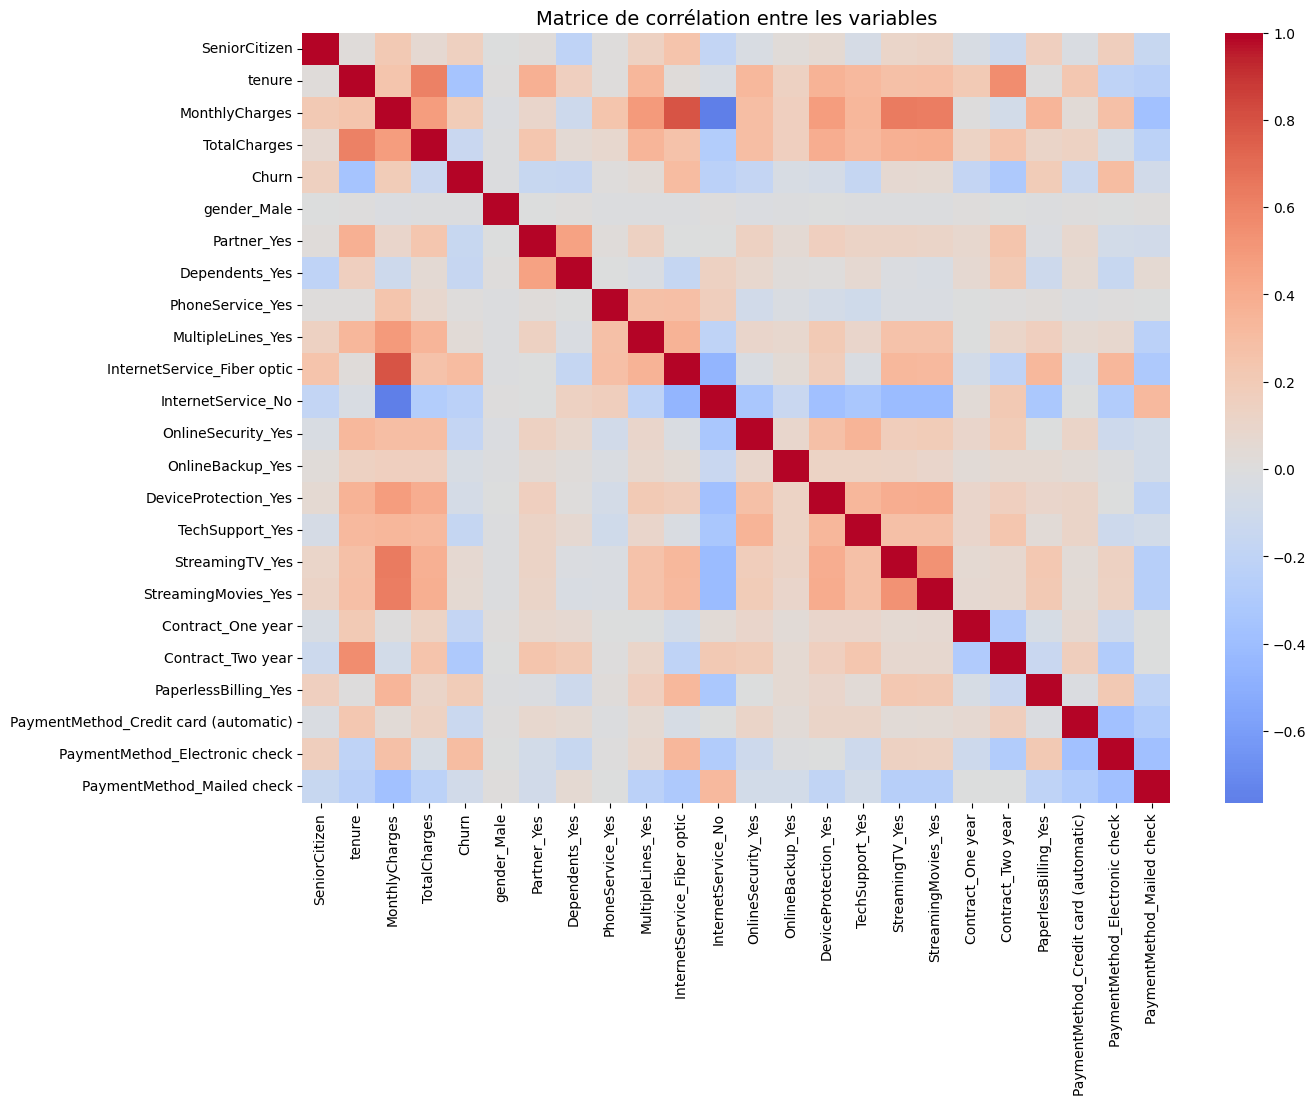

Corrélations avec la variable Churn :

Churn                             1.000000
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
PaperlessBilling_Yes              0.191825
SeniorCitizen                     0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
PhoneService_Yes                  0.011942
Name: Churn, dtype: float64
PaymentMethod_Credit card (automatic)   -0.134302
TotalCharges                            -0.147512
Partner_Yes                             -0.150448
Dependents_Yes                          -0.164221
TechSupport_Yes                         -0.164674
OnlineSecurity_Yes                      -0.171226
Contract_One year                       -0.177820
InternetService_No                      -0.227890
Contract_Two year                       -0.302253
tenure                                  -0.352229
Nam

In [12]:
# --- Étape : Matrice de corrélation ---

plt.figure(figsize=(14,10))

# Calcul des corrélations
corr = df.corr()

# Heatmap des corrélations avec seaborn
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)

plt.title("Matrice de corrélation entre les variables", fontsize=14)
plt.show()

# Zoom sur la corrélation avec le churn
corr_churn = corr["Churn"].sort_values(ascending=False)
print("Corrélations avec la variable Churn :\n")
print(corr_churn.head(10))   # les plus positives
print(corr_churn.tail(10))   # les plus négatives


Analyse exploratoire rapide

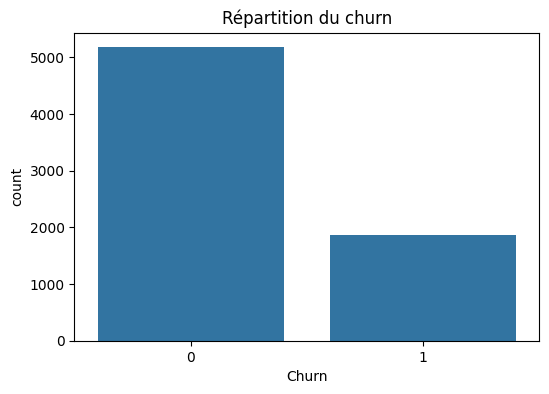

Répartition en pourcentage :
Non churn : 73.46%
Churn : 26.54%


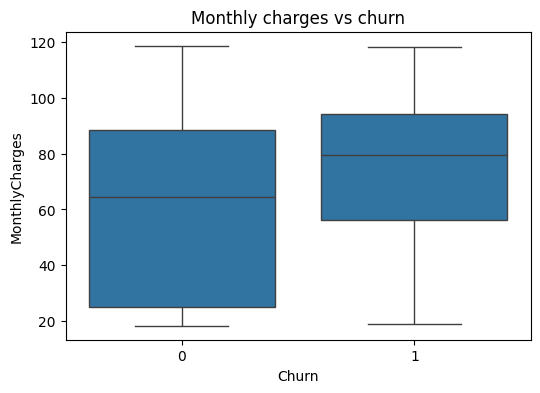

In [13]:
# 1. Répartition du churn
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Répartition du churn")
plt.show()

# Affichage des pourcentages de churn et non churn
churn_counts = df['Churn'].value_counts(normalize=True) * 100
print("Répartition en pourcentage :")
for val, pct in churn_counts.items():
    label = "Churn" if val == 1 else "Non churn"
    print(f"{label} : {pct:.2f}%")

# 2. MonthlyCharges vs Churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly charges vs churn")
plt.show()


Split train/test

In [14]:

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Standardisation

In [15]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Premier modèle : régression logistique

In [16]:

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# y_proba = model.predict_proba(X_test)[:,1]

print("Classification report :")
print(classification_report(y_test, y_pred))

Classification report :
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1552
           1       0.65      0.55      0.59       561

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.80      2113



 Matrice de confusion

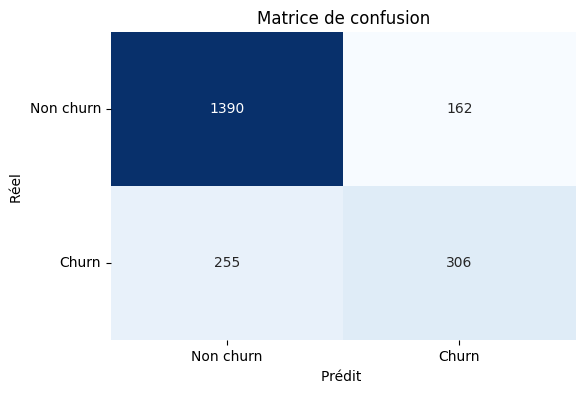

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matrice de confusion")
plt.xlabel("Prédit ")
plt.ylabel("Réel ")
plt.xticks([0.5, 1.5], ["Non churn", "Churn"])
plt.yticks([0.5, 1.5], ["Non churn", "Churn"], rotation=0)
plt.show()

Importance des variables

                        Feature      Coef
1                        tenure -0.828878
2                MonthlyCharges -0.695192
9   InternetService_Fiber optic  0.685648
10           InternetService_No -0.625666
18            Contract_Two year -0.560147
17            Contract_One year -0.297624
16          StreamingMovies_Yes  0.264758
15              StreamingTV_Yes  0.222609
8             MultipleLines_Yes  0.217537
19         PaperlessBilling_Yes  0.199882


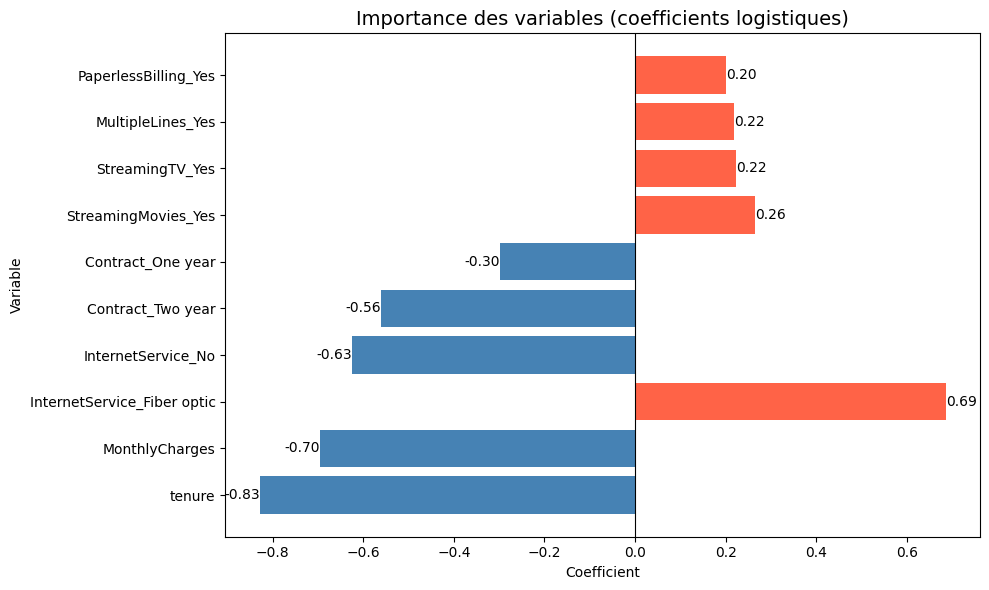

In [18]:

importance = pd.DataFrame({
    'Feature': X.columns,
    'Coef': model.coef_[0]
}).sort_values(by="Coef", key=abs, ascending=False)

print(importance.head(10))
# --- Importance des variables (régression logistique) ---

# Sélectionner les 10 plus fortes en valeur absolue
top_features = importance.head(10)

# Définir couleurs : rouge si coef > 0 (risque ↑), bleu si coef < 0 (fidélité ↑)
colors = ["tomato" if c > 0 else "steelblue" for c in top_features["Coef"]]

plt.figure(figsize=(10,6))
bars = plt.barh(top_features["Feature"], top_features["Coef"], color=colors)

plt.axvline(0, color="black", linewidth=0.8)
plt.title("Importance des variables (coefficients logistiques)", fontsize=14)
plt.xlabel("Coefficient")
plt.ylabel("Variable")

# Ajouter les valeurs numériques sur les barres
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", va='center',
             ha="left" if bar.get_width() > 0 else "right")

plt.tight_layout()
plt.show()

Incite à resilier :
- Connection fibre

Fidélise :
- Ancienneté
- Prix de l'abonnement


Vérifier l'hypothèse du métier : impact du nombre de services sur le churn

C:\Users\gabin\AppData\Local\Temp\ipykernel_19480\893592161.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="nb_services", y="Churn", data=df, ci=None, palette="viridis")
C:\Users\gabin\AppData\Local\Temp\ipykernel_19480\893592161.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="nb_services", y="Churn", data=df, ci=None, palette="viridis")


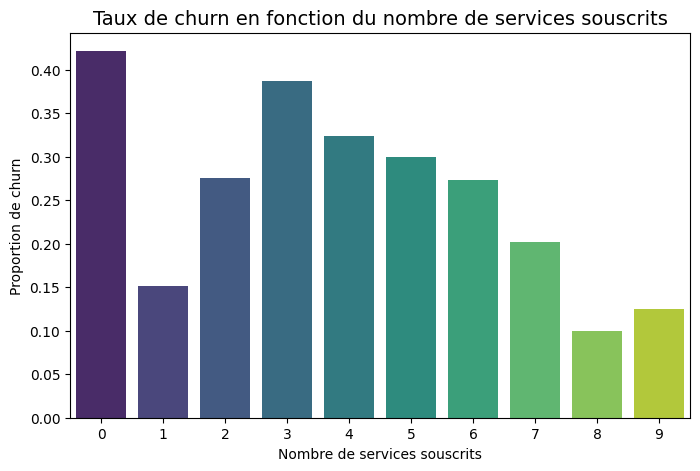

Corrélation nb_services vs churn : 0.020

Taux de churn par nombre de services :
 nb_services
0    0.421569
1    0.151674
2    0.275769
3    0.386792
4    0.323779
5    0.300209
6    0.273548
7    0.201699
8    0.100000
9    0.125000
Name: Churn, dtype: float64


In [19]:
# Liste des colonnes correspondant aux services souscrits
service_cols = [
    "PhoneService_Yes",
    "MultipleLines_Yes",
    "InternetService_Fiber optic",
    "OnlineSecurity_Yes",
    "OnlineBackup_Yes",
    "DeviceProtection_Yes",
    "TechSupport_Yes",
    "StreamingTV_Yes",
    "StreamingMovies_Yes"
]

# Créer une variable "nb_services"
df["nb_services"] = df[service_cols].sum(axis=1)

# Analyse : churn en fonction du nombre de services
plt.figure(figsize=(8,5))
sns.barplot(x="nb_services", y="Churn", data=df, ci=None, palette="viridis")
plt.title("Taux de churn en fonction du nombre de services souscrits", fontsize=14)
plt.ylabel("Proportion de churn")
plt.xlabel("Nombre de services souscrits")
plt.show()

# Vérifier corrélation
corr_nb_services = df["nb_services"].corr(df["Churn"])
print(f"Corrélation nb_services vs churn : {corr_nb_services:.3f}")

# Taux de churn détaillé par nb_services
churn_by_services = df.groupby("nb_services")["Churn"].mean()
print("\nTaux de churn par nombre de services :\n", churn_by_services)
